In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2
from PIL import Image
import requests
from io import BytesIO

from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.static.players import find_players_by_full_name

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from PIL import Image

In [2]:
from time import sleep
import tqdm

## Plot functions

In [3]:
import random
from matplotlib.patches import Circle, Rectangle, Arc

# Amazing function by Bradley Fay for plotting the nba court
# source: https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb
def draw_court(ax=None, color='black', lw=2, background_color="#EBEBE8", outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False, zorder=0)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed', zorder=0)
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color, zorder=0)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 138, linewidth=lw,
                               color=color, zorder=0)
    corner_three_b = Rectangle((220, -47.5), 0, 138, linewidth=lw, color=color, zorder=0)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22.13, theta2=157.87, linewidth=lw,
                    color=color, zorder=0)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]
    
    # Draw the half court line, baseline and side out bound lines
    outer_lines = Rectangle((-249, -48), 498, 470, linewidth=lw,
                            color=color, fill=None)
    court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [4]:
text_location_mapping = {
    ('Right Corner 3', 'Right Side(R)', '24+ ft.'): (-235, 50),
    ('Left Corner 3', 'Left Side(L)', '24+ ft.'): (235, 50),
    ('Above the Break 3', 'Center(C)', '24+ ft.'): (0, 260),
    ('Above the Break 3', 'Left Side Center(LC)', '24+ ft.'): (155, 230),
    ('Above the Break 3', 'Right Side Center(RC)', '24+ ft.'): (-155, 230),
    ('Restricted Area', 'Center(C)', 'Less Than 8 ft.'): (0, 20),
    ('Mid-Range', 'Center(C)', '16-24 ft.'): (0, 190),
    ('Mid-Range', 'Center(C)', '8-16 ft.') : (0, 150),  # merge prethodni
    ('Mid-Range', 'Left Side Center(LC)', '16-24 ft.'): (110, 180),
    ('Mid-Range', 'Right Side Center(RC)', '16-24 ft.'): (-110, 180),
    ('In The Paint (Non-RA)', 'Center(C)', '8-16 ft.'): (0, 110),
    ('In The Paint (Non-RA)', 'Center(C)', 'Less Than 8 ft.'): (0, 60),
    ('In The Paint (Non-RA)', 'Left Side(L)', '8-16 ft.'): (70, 80),  # merge s ovim dole
    ('Mid-Range', 'Left Side(L)', '8-16 ft.'): (120, 50),
    ('In The Paint (Non-RA)', 'Right Side(R)', '8-16 ft.'): (-70, 80),  # merge s ovim dole
    ('Mid-Range', 'Right Side(R)', '8-16 ft.'): (-120, 50),
    ('Mid-Range', 'Left Side(L)', '16-24 ft.'): (190, 50),
    ('Mid-Range', 'Right Side(R)', '16-24 ft.'): (-190, 50),
}

In [5]:
def plot_raw_shotchart(data_frame, title, mode="dark", plot_fg_made = False, assist_df=None, image_name=None):
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=(20, 20))
    
    #made_shots = data_frame.loc[data_frame.SHOT_MADE_FLAG == 1]
    #created_shots = data_frame.loc[data_frame.ACTION_TYPE.isin(created)]
    #catch_and_shoot = data_frame.loc[data_frame.ACTION_TYPE.isin(non_created)]
    yellow = '#FFCD00'
    
    paths = ax.scatter(
        x=data_frame.LOC_X,
        y=data_frame.LOC_Y,
        marker='o',
        c="#1D428A",
        edgecolors='#FEC524',
        s=400,
        alpha=0.95,
    )
    
    # ('Mid-Range', 'Right Side Center(RC)', '16-24 ft.')
    bball_gray = '#312f30'
    bball_white = '#dddee0'
    bball_orange = '#f87c24'
    bball_light_orange = '#fbaf7b'
    
    if mode == 'dark':
        background_color="#232323"
        font_color="#E8E8FF"
    else:
        background_color="#EBEBE8"
        font_color = "#454545"
        
    if plot_fg_made:
        original_df = data_frame
        df_by_zone_sum = original_df.groupby(by=['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE']).sum()
        df_by_zone_sum.loc[:, 'ZONE_PCT'] = (df_by_zone_sum.SHOT_MADE_FLAG / df_by_zone_sum.SHOT_ATTEMPTED_FLAG) * 100
        df_by_zone_median = original_df.groupby(by=['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE']).median()
        for index in range(len(df_by_zone_median)):
            loc_x = df_by_zone_median.iloc[index].LOC_X
            loc_y = df_by_zone_median.iloc[index].LOC_Y
            
            if df_by_zone_median.iloc[index].name not in text_location_mapping:
                continue
            loc_x, loc_y = text_location_mapping[df_by_zone_median.iloc[index].name]
            zone_percentage = df_by_zone_sum.iloc[index].ZONE_PCT
            zone_shots_made = df_by_zone_sum.iloc[index].SHOT_MADE_FLAG
            zone_shots_attempted = df_by_zone_sum.iloc[index].SHOT_ATTEMPTED_FLAG
            if zone_shots_made > 1:
                percentage = zone_shots_made / len(original_df) * 100
                ax.text(x=loc_x, y=loc_y+10, s=f"{percentage:.2f}%", ha='center', c='black', fontsize=18,
                       bbox={'facecolor': '#F3F3A9', 'alpha': 0.75, 'edgecolor': 'black'})
    
    
    # Changing court color
    #ax.set_facecolor('#FFFAFA')
    # Legend

    # Removing ticks
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.grid(False)
    
    player_id = data_frame.iloc[0].PLAYER2_ID
    #url = f"https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/{team_id}/2020/260x190/{player_id}.png"
    #response = requests.get(url)
    #img = Image.open(BytesIO(response.content))
    ab = AnnotationBbox(OffsetImage(plt.imread(f'player_imgs/{player_id}.png'), zoom=1.0), (172, -7.5), frameon=False)
    ax.add_artist(ab)

    # Title
    ax.set_title(title, size=32)
    
    # Drawing court
    draw_court(ax=ax,outer_lines=True, lw=3, color=bball_gray)
    ax.set_xlim(-251,251)
    ax.set_ylim(-65,425)
    
        
    ab = AnnotationBbox(OffsetImage(plt.imread(f'../../twitter_logo.png'), zoom=0.025), (142, -58), frameon=False)
    ax.add_artist(ab)

    #ab = AnnotationBbox(OffsetImage(plt.imread(f'../../twitter_logo.png'), zoom=0.05), (0.88, len(pivoted)+0.5), frameon=False)
    y_coord = -60
    #offset_image.set_offset((1100, 0))
    #ax.add_artist(offset_image)
    ax.text(x=150, y=y_coord, ha='left', s='@daniel_bratulic', size=18, color=bball_gray)
    ax.text(x=-220, y=y_coord, ha='left', s='source: nba.com', size=18, color=bball_gray)

    
    #ax.legend(loc='upper right')
    
    if image_name:
        fig.savefig(image_name, bbox_inches='tight')

## Fetching data

In [6]:
def get_assist_df(player_name, team_name):
    team_id = find_teams_by_full_name(team_name)[0]['id']

    team = ShotChartDetail(team_id=team_id, player_id=0, season_nullable='2020-21')

    team_df = team.get_data_frames()[0]
    player_id = find_players_by_full_name(player_name)[0]['id']

    team_df = team_df.loc[team_df.SHOT_MADE_FLAG == 1]

    team_df = team_df.loc[team_df.PLAYER_ID != player_id]
    team_df.LOC_X = -team_df.LOC_X
    
    game_finder = LeagueGameFinder(player_id_nullable=player_id, player_or_team_abbreviation='P', season_nullable='2020-21', season_type_nullable='Regular Season')

    games_df = game_finder.get_data_frames()[0]
    unique_game_ids = games_df.GAME_ID.unique()
    df = PlayByPlayV2(game_id=unique_game_ids[-1]).get_data_frames()[0]

    assist_frames = []
    for game_id in tqdm.tqdm(unique_game_ids):
        pbp_df = PlayByPlayV2(game_id=game_id).get_data_frames()[0]
        pbp_df = pbp_df.loc[(pbp_df.PLAYER2_ID == player_id) & (pbp_df.EVENTMSGTYPE == 1)]
        assist_frames.append(pbp_df)
        sleep(0.25)
    concated = pd.concat(assist_frames, ignore_index=True)
    merged_df = pd.merge(left=team_df, right=concated, left_on=['GAME_ID', 'GAME_EVENT_ID'], right_on=['GAME_ID', 'EVENTNUM'], suffixes=('_shot', '_assist'))

    
    return merged_df

In [7]:

from nba_api.stats.static.teams import find_teams_by_full_name

team_id = find_teams_by_full_name("Denver Nuggets")[0]['id']

team = ShotChartDetail(team_id=team_id, player_id=0, season_nullable='2020-21')

team_df = team.get_data_frames()[0]



In [8]:
player_id = find_players_by_full_name("Nikola Jokic")[0]['id']

team_df = team_df.loc[team_df.SHOT_MADE_FLAG == 1]

team_df = team_df.loc[team_df.PLAYER_ID != player_id]

team_df.LOC_X = -team_df.LOC_X


In [9]:

game_finder = LeagueGameFinder(player_id_nullable=player_id, player_or_team_abbreviation='P', season_nullable='2020-21', season_type_nullable='Regular Season')

games_df = game_finder.get_data_frames()[0]

unique_game_ids = games_df.GAME_ID.unique()

df = PlayByPlayV2(game_id=unique_game_ids[-1]).get_data_frames()[0]


In [10]:
assist_frames = []
for game_id in tqdm.tqdm(unique_game_ids):
    pbp_df = PlayByPlayV2(game_id=game_id).get_data_frames()[0]
    pbp_df = pbp_df.loc[(pbp_df.PLAYER2_ID == player_id) & (pbp_df.EVENTMSGTYPE == 1)]
    assist_frames.append(pbp_df)
    sleep(0.25)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:48<00:00,  1.39it/s]


In [11]:
concated = pd.concat(assist_frames, ignore_index=True)

merged_df = pd.merge(left=team_df, right=concated, left_on=['GAME_ID', 'GAME_EVENT_ID'], right_on=['GAME_ID', 'EVENTNUM'], suffixes=('_shot', '_assist'))

In [12]:
jokic_df = merged_df

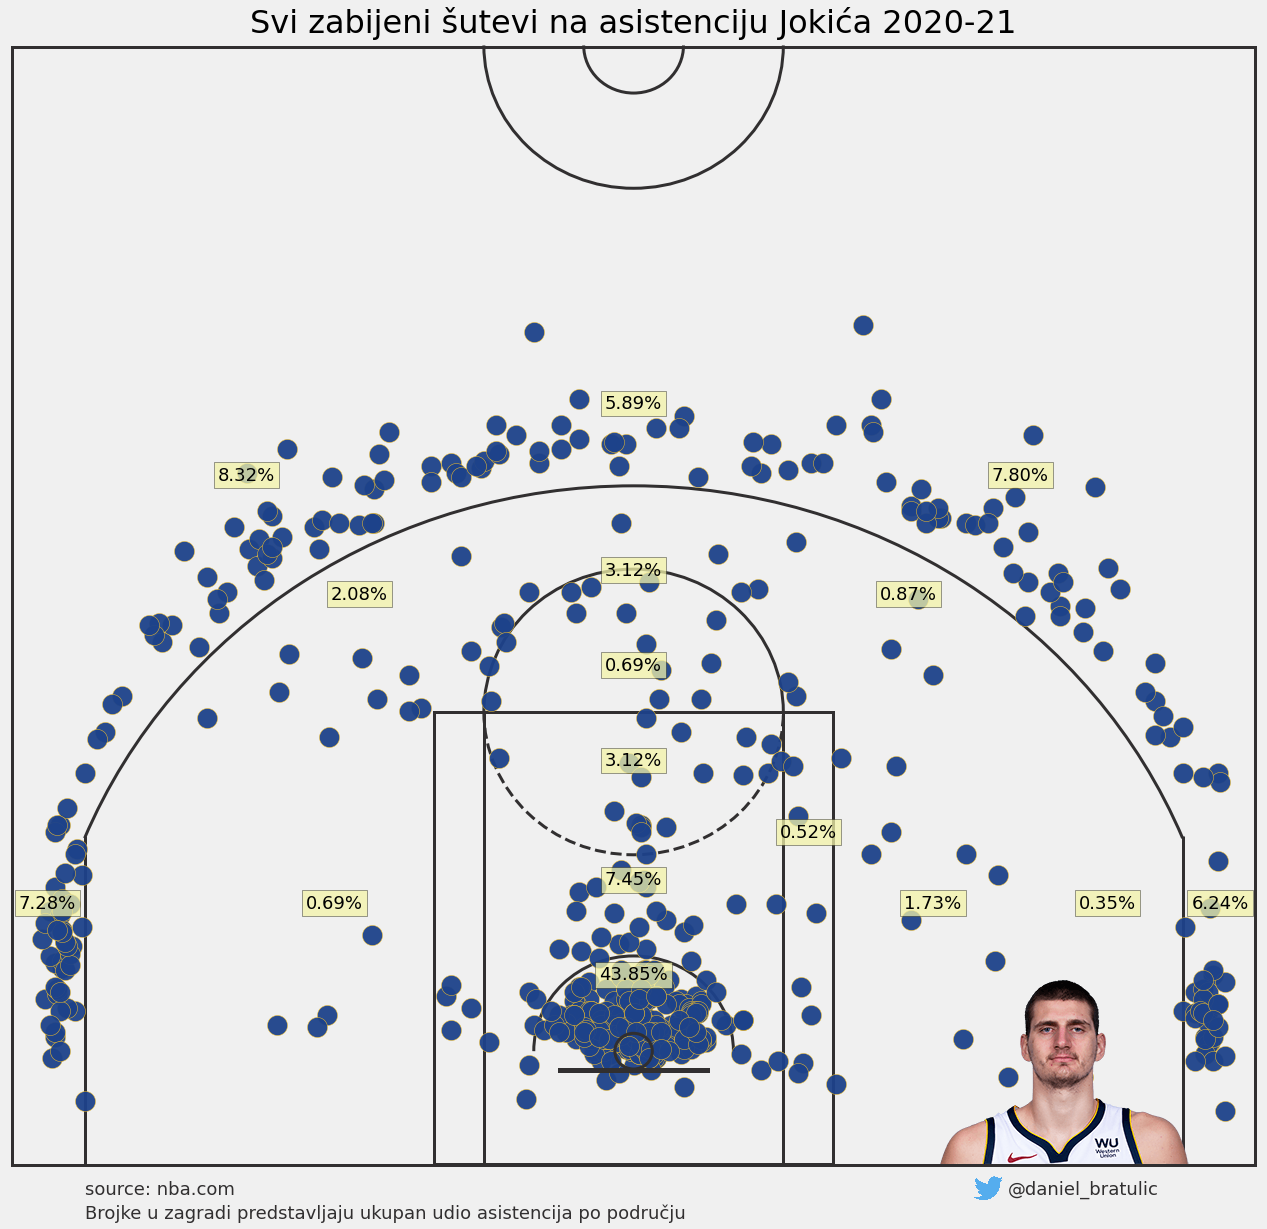

In [32]:
plot_raw_shotchart(merged_df, title='Svi zabijeni šutevi na asistenciju Jokića 2020-21', plot_fg_made=True)

## Doncic

In [14]:
doncic_df = get_assist_df(player_name="Luka Doncic", team_name="Dallas Mavericks")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


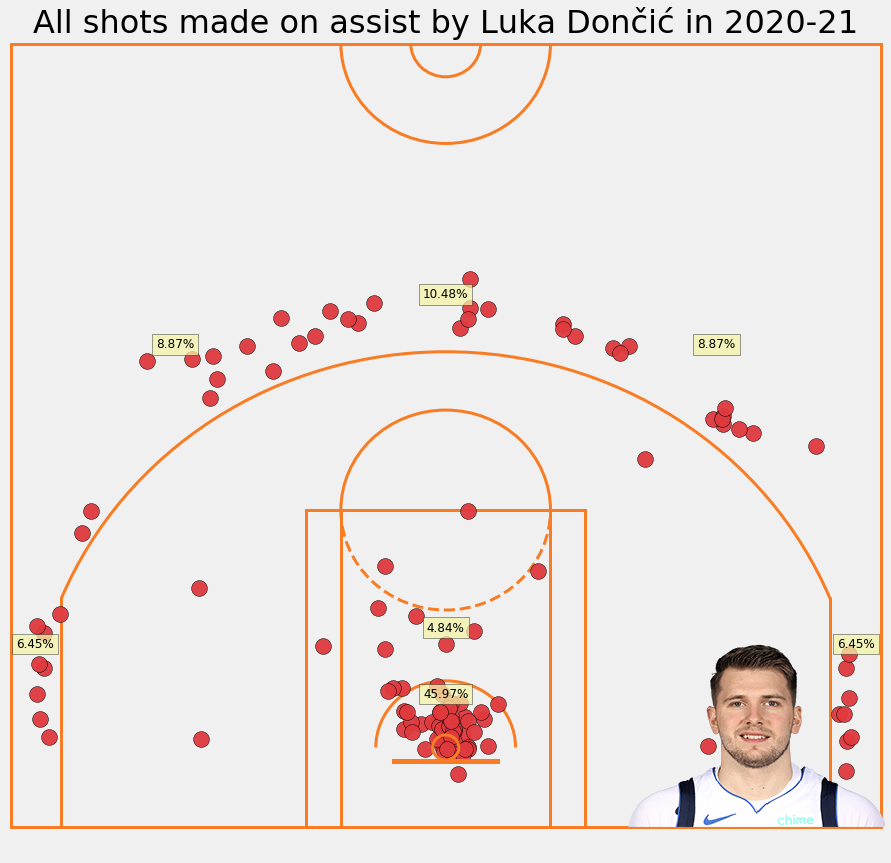

In [61]:
plot_raw_shotchart(doncic_df, title='All shots made on assist by Luka Dončić in 2020-21', plot_fg_made=True)

## LeBron

In [16]:
lebron_df = get_assist_df(player_name="LeBron James", team_name="Los Angeles Lakers")


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.15it/s]


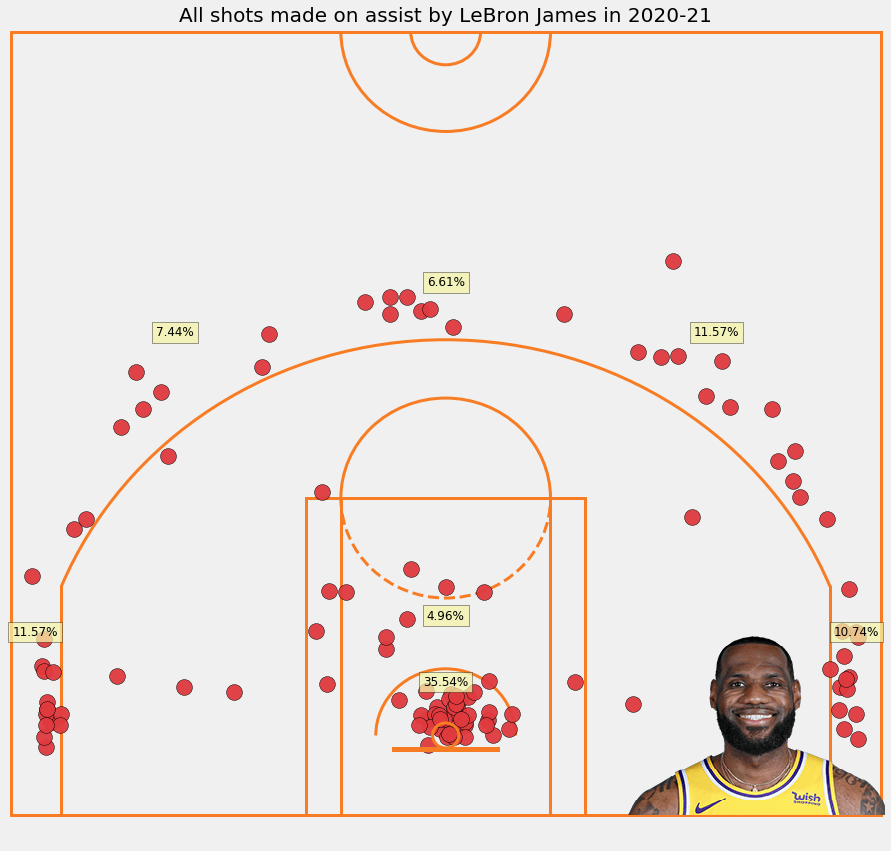

In [59]:
plot_raw_shotchart(lebron_df, title='All shots made on assist by LeBron James in 2020-21', plot_fg_made=True)

## Julius Randle

In [9]:
df = get_assist_df(player_name="Julius Randle", team_name="New York Knicks")




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:48<00:00,  1.47it/s]


NameError: name 'lebron_df' is not defined

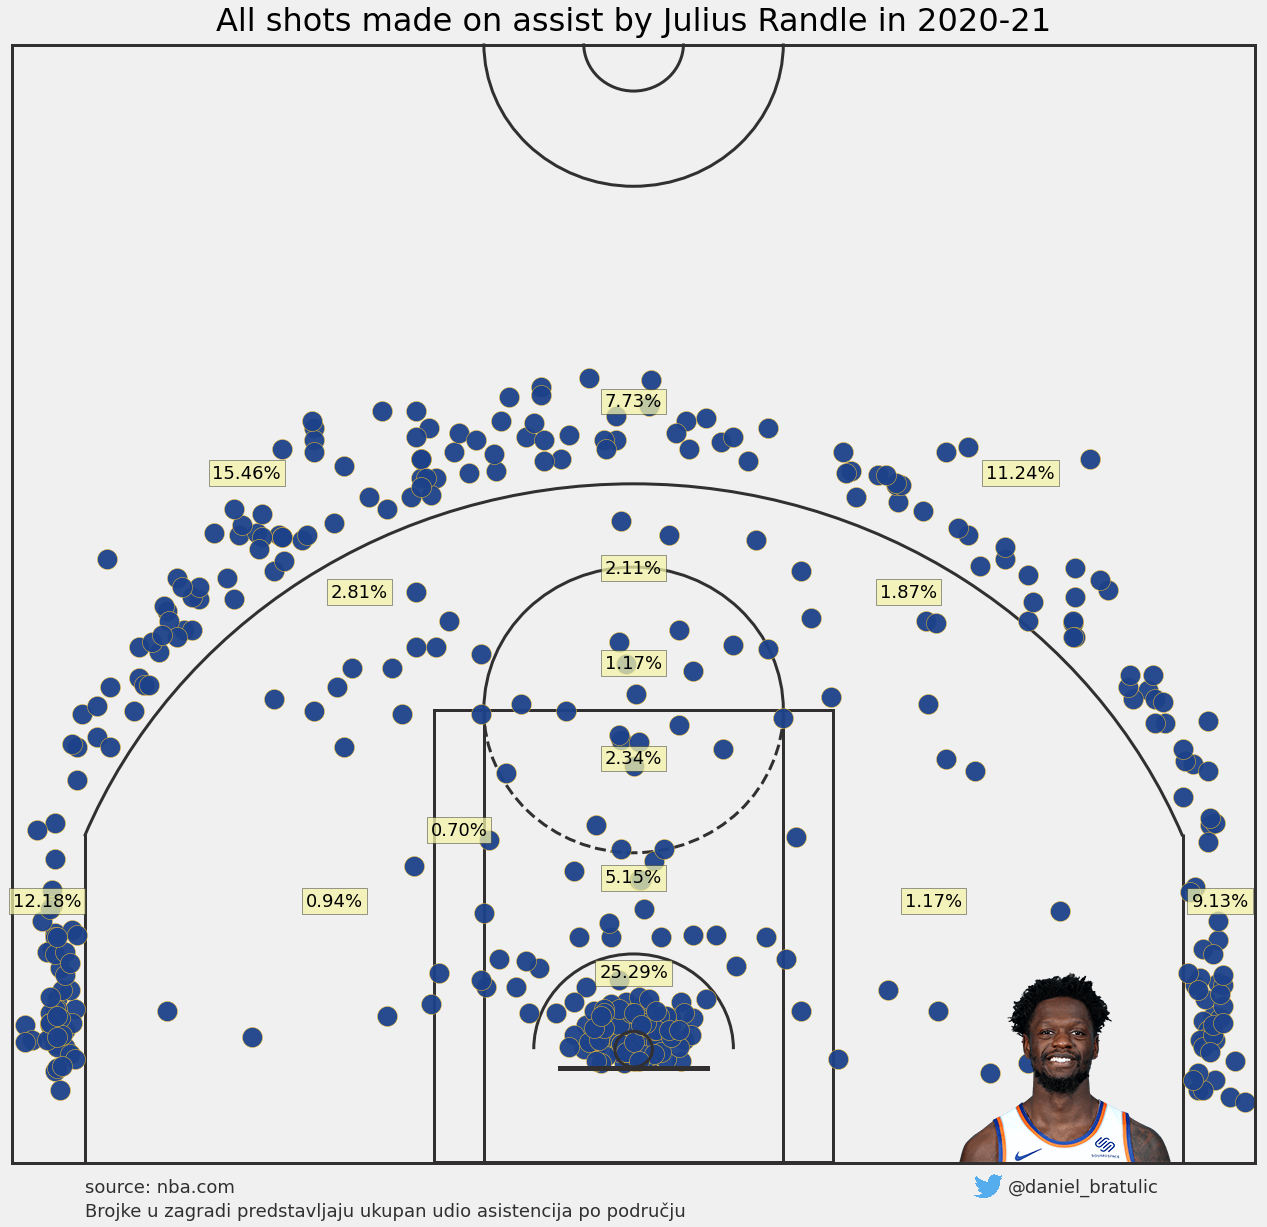

In [10]:
plot_raw_shotchart(df, title='All shots made on assist by Julius Randle in 2020-21', plot_fg_made=True)